In [ ]:
#https://kieranrcampbell.github.io/blog/2016/05/15/gibbs-sampling-bayesian-linear-regression.html

# another fun one
#https://www.nguyenmbquan.space/gibbs-sampling-with-data-augmentation/

In [8]:
import numpy as np

%matplotlib inline
#from seaborn import plt
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.figsize'] = (10, 5)

In [9]:
def sample_beta_0(y, x, beta_1, tau, mu_0, tau_0):
    N = len(y)
    assert len(x) == N
    precision = tau_0 + tau * N
    mean = tau_0 * mu_0 + tau * np.sum(y - beta_1 * x)
    mean /= precision
    return np.random.normal(mean, 1 / np.sqrt(precision))

def sample_beta_1(y, x, beta_0, tau, mu_1, tau_1):
    N = len(y)
    assert len(x) == N
    precision = tau_1 + tau * np.sum(x * x)
    mean = tau_1 * mu_1 + tau * np.sum( (y - beta_0) * x)
    mean /= precision
    return np.random.normal(mean, 1 / np.sqrt(precision))

def sample_tau(y, x, beta_0, beta_1, alpha, beta):
    N = len(y)
    alpha_new = alpha + N / 2
    resid = y - beta_0 - beta_1 * x
    beta_new = beta + np.sum(resid * resid) / 2
    return np.random.gamma(alpha_new, 1 / beta_new)

In [11]:
beta_0_true = -1
beta_1_true = 2
tau_true = 1

N = 50
x = np.random.uniform(low = 0, high = 4, size = N)
y = np.random.normal(beta_0_true + beta_1_true * x, 1 / np.sqrt(tau_true))

Text(0, 0.5, 'y')

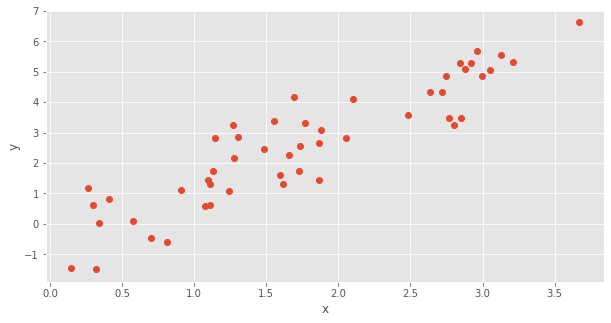

In [12]:
plt.style.use('ggplot')
synth_plot = plt.plot(x, y, "o")
plt.xlabel("x")
plt.ylabel("y")

Text(0, 0.5, 'y')

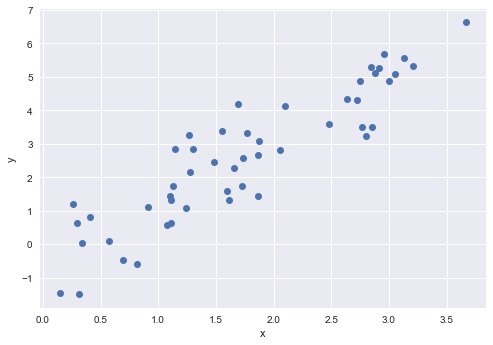

In [18]:
plt.style.use('seaborn')
synth_plot = plt.plot(x, y, "o")
plt.xlabel("x")
plt.ylabel("y")

In [20]:
## specify initial values
init = {"beta_0": 0,
        "beta_1": 0,
        "tau": 2}

## specify hyper parameters
hypers = {"mu_0": 0,
         "tau_0": 1,
         "mu_1": 0,
         "tau_1": 1,
         "alpha": 2,
         "beta": 1}

def gibbs(y, x, iters, init, hypers):
    assert len(y) == len(x)
    beta_0 = init["beta_0"]
    beta_1 = init["beta_1"]
    tau = init["tau"]
    
    trace = np.zeros((iters, 3)) ## trace to store values of beta_0, beta_1, tau
    
    for it in range(iters):
        beta_0 = sample_beta_0(y, x, beta_1, tau, hypers["mu_0"], hypers["tau_0"])
        beta_1 = sample_beta_1(y, x, beta_0, tau, hypers["mu_1"], hypers["tau_1"])
        tau = sample_tau(y, x, beta_0, beta_1, hypers["alpha"], hypers["beta"])
        trace[it,:] = np.array((beta_0, beta_1, tau))
        
    trace = pd.DataFrame(trace)
    trace.columns = ['beta_0', 'beta_1', 'tau']
        
    return trace

In [21]:
iters = 1000
trace = gibbs(y, x, iters, init, hypers)

Text(0, 0.5, 'Parameter value')

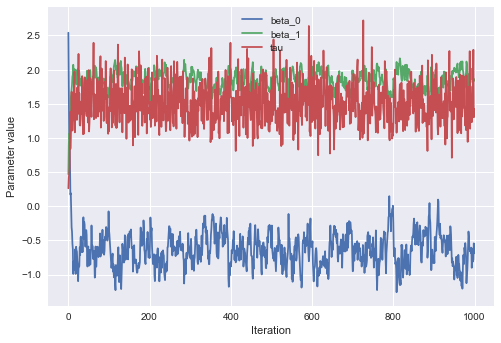

In [22]:
traceplot = trace.plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("Parameter value")

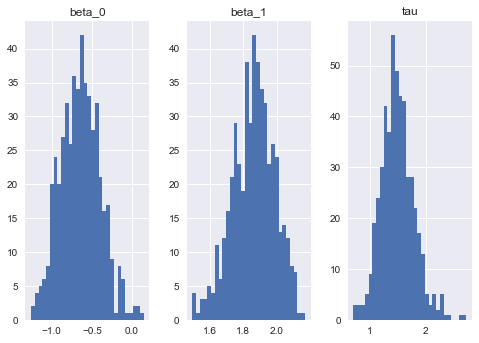

In [23]:
trace_burnt = trace[500:999]
hist_plot = trace_burnt.hist(bins = 30, layout = (1,3))

In [24]:
print(trace_burnt.median())
print(trace_burnt.std())

beta_0   -0.639588
beta_1    1.868967
tau       1.477753
dtype: float64
beta_0    0.247771
beta_1    0.125089
tau       0.295363
dtype: float64


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import gif
from IPython.display import Image
from random import random

In [ ]:
def plot_gaussian_from_points(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    Returns
    -------
    matplotlib.patches.Ellipse
    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if len(x) != len(y):
        raise ValueError("x and y must be the same size")
    if len(x) < 2:
        raise ValueError("Need more data.")
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def plot_gaussian_from_parameters(mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    Parameters
    ----------
	mean : array-like, shape (2, )
    	Mean vector
    cov : array-like, shape (2,2)
    	Covariance matrix
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    Returns
    -------
    matplotlib.patches.Ellipse
    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if len(mean) != 2:
        raise ValueError("Mean vector length should be 2.")
    if (cov.shape != (2, 2)):
    	raise ValueError("Covariance should be a 2x2 matrix.")
    #checking if cov is symmetric pos semidefinite
    if(cov[0, 1] != cov[1, 0]):
        raise ValueError("Covariance should be symmetric.")
    if(cov[0, 0] < 0 or cov[0, 0]*cov[1,1] - cov[0,1]**2 < 0):
        raise ValueError("Covariance should be positive semidefinite.")

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [ ]:
def conditional_sampler(sampling_index, current_x, mean, cov):
    conditioned_index = 1 - sampling_index
    a = cov[sampling_index, sampling_index]
    b = cov[sampling_index, conditioned_index]
    c = cov[conditioned_index, conditioned_index]
    
    mu = mean[sampling_index] + (b * (current_x[conditioned_index] - mean[conditioned_index]))/c
    sigma = np.sqrt(a-(b**2)/c)
    new_x = np.copy(current_x)
    new_x[sampling_index] = np.random.randn()*sigma + mu
    return new_x

In [ ]:
@gif.frame
def plot_samples(samples, num_samples, tmp_points, num_tmp, title="Gibbs Sampling", xlims=(-11, 11), ylims=(-11, 11)):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca()
    
    # Plot the true distribution
    plot_gaussian_from_parameters(mean, cov, ax, n_std=2, edgecolor='g', alpha=0.5, label="True Distribution")
    
    # Plot sampled points
    ax.scatter(samples[:num_samples, 0], samples[:num_samples, 1], c='b', s=10, label="Sampled Points")
    ax.scatter(samples[0, 0], samples[0, 1], marker='*', c='g', s=60, label="Initial Point")
    
    # Plot samples from conditional distribution
    ax.scatter(tmp_points[:num_tmp, 0], tmp_points[:num_tmp, 1], c='r', alpha=0.4, s=5, label="Temporary Points")
    
    # Keeping the axes scales same for good GIFS
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
    # Plot lines
    if(num_tmp > 0):
        ax.plot([samples[num_samples-1, 0], tmp_points[num_tmp-1, 0]], 
                [samples[num_samples-1, 1], tmp_points[num_tmp-1, 1]], c='k', alpha=0.25)
        # Plot estimated Gaussian, ignoring the starting point
        if(num_samples > 2):
            plot_gaussian_from_points(samples[1:num_samples, 0], samples[1:num_samples, 1], 
                                      ax, n_std=2, edgecolor='b', alpha=0.5, label="Estimated Distribution")
    
    ax.legend(loc='upper left')
    ax.set_title(title)

In [ ]:
def gibbs_sampler(initial_point, num_samples, mean, cov, create_gif=True):

    frames = []  # for GIF
    point = np.array(initial_point)
    samples = np.empty([num_samples+1, 2])  #sampled points
    samples[0] = point
    tmp_points = np.empty([num_samples, 2]) #inbetween points

    for i in range(num_samples):

        # Sample from p(x_0|x_1)
        point = conditional_sampler(0, point, mean, cov)
        tmp_points[i] = point
        if(create_gif):
            frames.append(plot_samples(samples, i+1, tmp_points, i+1, title="Num Samples: " + str(i)))
            
        # Sample from p(x_1|x_0)
        point = conditional_sampler(1, point, mean, cov)
        samples[i+1] = point
        if(create_gif):
            frames.append(plot_samples(samples, i+2, tmp_points, i+1, title="Num Samples: " + str(i+1)))
            
    if(create_gif):
        return samples, tmp_points, frames
    else:
        return samples, tmp_points

In [ ]:
mean = np.array([0, 0])
cov = np.array([[10, 3], 
                [3, 5]])

In [ ]:
# Plot true distribution
fig = plt.figure(figsize=(10, 8))
ax = fig.gca()
plot_gaussian_from_parameters(mean, cov, ax, n_std=2, edgecolor='g', label="True Distribution")
ax.scatter(mean[0], mean[1], c='g')
ax.set_xlim((-11, 11))
ax.set_ylim((-11, 11))
ax.legend(loc='upper left')
plt.show()

In [ ]:
initial_point = [-9.0, -9.0]
num_samples = 500
samples, tmp_points, frames = gibbs_sampler(initial_point, num_samples, mean, cov, create_gif=True)

In [ ]:
# Creating the GIF
gif.save(frames, "gibbs.gif", duration=150)
Image(filename="gibbs.gif")